### Setup and initializations

In [1]:
import datetime as dt
import math
import warnings
from math import exp, log, sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import splev, splrep
from scipy.optimize import brute, fmin

pd.options.mode.chained_assignment = None
plt.style.use("seaborn")
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.rcParams["figure.figsize"] = (10, 6)
warnings.simplefilter(action="ignore", category=FutureWarning)

### Constants and globals

Here below are some constants which can be used to tweak of functions behavior in this notebook.

In [2]:
# MSE threshold
MAX_MSE_H93 = 500.0
MAX_MSE_BATES = 5000.0

# Param thresholds
KAPPA_MIN = 0.0
THETA_MIN = 0.005
SIGMA_MIN = 0.0
RHO_MIN = -1.0
RHO_MAX = 1.0
LAMBDA_MIN = 0.0
MU_MIN = -0.6
MU_MAX = 0.0
DELTA_MIN = 0.0

# Output settings
OUTPUT_EVERY_ROW = 25

# params index
KAPPA_V = 0
THETA_V = 1
SIGMA_V = 2
RHO = 3
V_0 = 4
LAMBDA = 5
MU = 6
DELTA = 7
KAPPA_R = 0
THETA_R = 1
SIGMA_R = 2

# Bates params
USE_REGULARIZATION = True

# Other given fixed parameters
NUMBER_OF_TRADING_DAYS = 250
NUMBER_OF_DAYS_RATES = 360

r = 0.015
S0 = 232.90
BANK_COMMISSION = 0.04

# Option types
EUROPEAN_OPTION = "European"
AMERICAN_OPTION = "American"
ASIAN_OPTION = "Asian"
CALL_OPTION = "Call"
PUT_OPTION = "Put"

### Step 0

Here we chose to fetch option data provided for this project

In [3]:
# Options data file
OPTIONS_DATA_FILENAME = "MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx"

# ----------------------------------------------------#
# Reads option data from provided xls file
# ----------------------------------------------------#
def read_options_data(filename):
    # the path to the option data file
    options = pd.read_excel(filename)

    # pre-process the options data
    options["T"] = (
        options["Days to maturity"] / NUMBER_OF_TRADING_DAYS
    )  # express in term of year
    options["r"] = r  # rate given in project assignment
    return options


# Options dataset
options = read_options_data(OPTIONS_DATA_FILENAME)
options.head()

,Days to maturity,Strike,Price,Type,T,r
0,15,227.5,10.52,C,0.06,0.015
1,15,230.0,10.05,C,0.06,0.015
2,15,232.5,7.75,C,0.06,0.015
3,15,235.0,6.01,C,0.06,0.015
4,15,237.5,4.75,C,0.06,0.015


### Common function implementations

Here below are implementations of functions used in this notebook elsewhere.

Generic function implementations

In [4]:
# ----------------------------------------------------#
# Draws plot for given series
# ----------------------------------------------------#
def draw_plot(series1, xLabel, yLabel, title, series2=None, labels=[]):
    fig, ax = plt.subplots()
    if len(labels) != 0:
        series1.plot(ax=ax, label=labels[0])
    else:
        series1.plot(ax=ax)
    if series2 is not None:
        ax2 = ax.twinx()
        if len(labels) == 2:
            series2.plot(ax=ax2, color="orange", alpha=0.6, label=labels[1])
        else:
            series2.plot(ax=ax2, color="orange", alpha=0.6)
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax.legend(h1 + h2, l1 + l2, loc=2)

    ax.set_xlabel(xLabel, fontsize=14)
    ax.set_ylabel(yLabel, fontsize=14)

    ax.set_title(title, fontsize=14)
    fig.tight_layout()
    plt.show()


# ----------------------------------------------------#
# Provides filtered data matching maturity date
# ----------------------------------------------------#
def set_options_data_filter(days_to_maturity):
    global options_filtered
    options_15_mask = options["Days to maturity"] == days_to_maturity
    options_15_mask &= options["Type"] == "C"
    options_filtered = options[options_15_mask]

### Heston (1993) function implementations

In [5]:
# ----------------------------------------------------#
# Implementation for Heston(1993) characterstic func
# ----------------------------------------------------#
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v ** 2 * (-u * 1j - u ** 2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v ** 2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v ** 2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value


# ----------------------------------------------------#
# Implementation for Heston(1993) error function
# ----------------------------------------------------#
def H93_error_function(call_value_func, p0):
    """ Error function for parameter calibration in Heston model.
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if (
        kappa_v < KAPPA_MIN
        or theta_v < THETA_MIN
        or sigma_v < SIGMA_MIN
        or rho < RHO_MIN
        or rho > RHO_MAX
    ):
        return MAX_MSE_H93
    if 2 * kappa_v * theta_v < sigma_v ** 2:
        return MAX_MSE_H93
    squared_error = []
    for row, option in options_filtered.iterrows():
        model_value = call_value_func(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        squared_error.append((model_value - option["Price"]) ** 2)
    MSE = sum(squared_error) / len(squared_error)
    min_MSE = min(min_MSE, MSE)
    if i % OUTPUT_EVERY_ROW == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE


# ----------------------------------------------------#
# Calculcates call option values for Heston(1993)
# ----------------------------------------------------#
def H93_calculate_model_values(call_value_func, p0):
    """ Calculates all model values given parameter vector p0. """
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    values = []
    for row, option in options_filtered.iterrows():
        model_value = call_value_func(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        values.append(model_value)
    return np.array(values)

### Heston (1993) using Lewis(2001) method implementations

In [6]:
# ----------------------------------------------------#
# Implementation for Heston(1993) Lewis(2001) integral
# unction
# ----------------------------------------------------#
def H93_Lewis_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value


# ----------------------------------------------------#
# Implementation for Heston(1993) call value function
# ----------------------------------------------------#
def H93_Lewis_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    """
    int_value = quad(
        lambda u: H93_Lewis_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value


# ----------------------------------------------------#
# Implementation for Heston(1993) error function
# ----------------------------------------------------#
def H93_Lewis_error_function(p0):
    return H93_error_function(H93_Lewis_call_value, p0)


# ----------------------------------------------------#
# Calculates call option values for Heston(1993)
# via Lewis(2001)
# ----------------------------------------------------#
def H93_Lewis_calculate_model_values(p0):
    """ Calculates all model values given parameter vector p0. """
    return H93_calculate_model_values(H93_Lewis_call_value, p0)

### Heston (1993) using Carr-Madan(1999) method implementations

In [7]:
def H93_CM99_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha ** 2 + alpha - vo ** 2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue


# ----------------------------------------------------#
# Implementation for Heston(1993) error function
# ----------------------------------------------------#
def H93_CM99_error_function(p0):
    return H93_error_function(H93_CM99_call_FFT, p0)


# ----------------------------------------------------#
# Calculates call option values for Heston(1993)
# via Lewis(2001)
# ----------------------------------------------------#
def H93_CM99_calculate_model_values(p0):
    return H93_calculate_model_values(H93_CM99_call_FFT, p0)

### Monte Carlo simulation implementations

In [8]:
# ----------------------------------------------------#
# Implementation for Heston model for option
# Returns option value
# ----------------------------------------------------#
def heston_model_mc_option_value(
    S0,
    K,
    T,
    r,
    σ,
    option_type,
    call_put,
    ν0,
    κ,
    θ,
    ρ,
    iterations=100_000,
    steps=255,
    up_down="",
    barrier=-1,
):
    print(
        "\x1b[35mPricing "
        + option_type
        + " "
        + call_put
        + " option using Monte Carlo simulation...\x1b[0m"
    )
    print(f"Option params: S0: {S0}, K:{K}, T:{T}, r:{r}, σ:{σ}")
    print(f"Model params: ν0:{ν0}, κ:{κ}, θ:{θ}, ρ:{ρ}")
    if barrier != -1:
        print(f"Barrier option params: Direction:{up_down}, Barrier:{barrier}")

    S = heston_model_paths(S0, K, T, r, σ, ν0, κ, θ, ρ, iterations, steps)
    value = round(
        simulated_asset_option(
            S, K, T, r, option_type, call_put, iterations, steps, up_down, barrier
        ),
        2,
    )

    print(
        "\x1b[32m "
        + option_type
        + f" option price using Heston model is \x1b[0m${value}"
    )
    return value


# ----------------------------------------------------#
# Implementation for Heston model paths for an asset
# ----------------------------------------------------#
def heston_model_paths(S0, K, T, r, σ, ν0, κ, θ, ρ, iterations, steps):
    no_of_rvs = 2
    W = np.random.standard_normal((no_of_rvs, steps + 1, iterations))
    dt = T / steps
    sqrt_dt = np.sqrt(dt)

    cov_matrix = np.array([[1.0, ρ], [ρ, 1.0]])
    cho_matrix = np.linalg.cholesky(cov_matrix)

    v = np.zeros((steps + 1, iterations), dtype=float)
    v[0] = ν0

    S = np.zeros((steps + 1, iterations), dtype=float)
    S[0] = S0

    for step in range(1, steps + 1):
        ϵ = np.dot(cho_matrix, W[:, step])
        v[step] = np.maximum(
            0,
            v[step - 1]
            + κ * (θ - v[step - 1]) * dt
            + np.sqrt(v[step - 1]) * σ * ϵ[1] * sqrt_dt,
        )

        S[step] = S[step - 1] * np.exp(
            (r - 0.5 * v[step]) * dt + np.sqrt(v[step]) * ϵ[0] * sqrt_dt
        )
    return S


# ----------------------------------------------------#
# Implementation for pricing American and European options
# given asset paths simulated using different models
# ----------------------------------------------------#
def simulated_asset_option(
    S,
    K,
    T,
    r,
    option_type,
    call_put,
    iterations=100_000,
    steps=255,
    up_down="",
    barrier=-1,
):
    dt = T / steps
    O = np.zeros((steps + 1, iterations))

    # Hanle Asian option here
    if option_type == ASIAN_OPTION:
        if call_put == CALL_OPTION:
            O[steps, :] = np.maximum(np.mean(S[:,], axis=0) - K, 0)
        else:
            O[steps, :] = np.maximum(K - np.mean(S[:,], axis=0), 0)
    else:  # Needed for all other type of options
        if call_put == CALL_OPTION:
            O[steps, :] = np.maximum(S[-1, :] - K, 0)
        else:
            O[steps, :] = np.maximum(K - S[-1, :], 0)

    # Handle American option here
    for step in range(steps, 0, -1):
        if option_type == AMERICAN_OPTION:
            if call_put == CALL_OPTION:
                O[step - 1, :] = np.maximum(
                    S[step - 1, :] - K, np.exp(-r * dt) * O[step, :]
                )
            else:
                O[step - 1, :] = np.maximum(
                    K - S[step - 1, :], np.exp(-r * dt) * O[step, :]
                )
        else:
            if call_put == CALL_OPTION:
                O[0, :] = np.exp(-r * T) * (O[steps, :])
            else:
                O[0, :] = np.exp(-r * T) * (O[steps, :])
            break
    # Handle barrier option here
    if barrier != -1:
        if up_down == "u" or up_down == "U":
            O[0, :] = np.where(
                np.max(S[:], axis=0) >= barrier, O[0, :], np.zeros_like(O[0, :])
            )
        elif up_down == "d" or up_down == "D":
            O[0, :] = np.where(
                np.min(S[:], axis=0) <= barrier, O[0, :], np.zeros_like(O[0, :])
            )
    return np.mean(O[0, :])


# ----------------------------------------------------#
# Calculates call option values for Monte Carlo
# ----------------------------------------------------#
def heston_model_mc_option_values(p0, maturity, option_type, call_or_put):
    """ Calculates all model values given parameter vector p0. """
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    values = []
    for row, option in options_filtered.iterrows():
        model_value = heston_model_mc_option_value(
            S0,
            option["Strike"],
            maturity,
            option["r"],
            p0[SIGMA_V],
            option_type,
            call_or_put,
            p0[V_0],
            p0[KAPPA_V],
            p0[THETA_V],
            p0[RHO],
        )
        values.append(model_value)
    return np.array(values)

### Bates(1996) function implementations

In [9]:
def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value


def B96_error_function_full(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    if (
        p0[KAPPA_V] < KAPPA_MIN
        or p0[THETA_V] < THETA_MIN
        or p0[SIGMA_V] < SIGMA_MIN
        or p0[RHO] < RHO_MIN
        or p0[RHO] > RHO_MAX
        or p0[V_0] < 0.0
        or p0[LAMBDA] < 0.0
        or p0[MU] < -0.6
        or p0[MU] > 0.0
        or p0[DELTA] < 0.0
    ):
        return MAX_MSE_BATES

    if 2 * p0[KAPPA_V] * p0[THETA_V] < p0[SIGMA_V] ** 2:
        return MAX_MSE_BATES
    se = []
    for row, option in options_filtered.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE


def B96_error_function(p0, *option_params_heston):
    """
    Error function for Bates (1996) model
    """

    global i, min_MSE, USE_REGULARIZATION, opt_params_lewis_bates_initial
    lamb, mu, delta = p0
    kappa_v, theta_v, sigma_v, rho, v0 = option_params_heston

    if lamb < LAMBDA_MIN or mu < MU_MIN or mu > MU_MAX or delta < DELTA_MIN:
        return MAX_MSE_BATES
    se = []
    for row, option in options_filtered.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print(
            "%4d |" % i,
            np.array(np.concatenate((p0, option_params_heston))),
            "| %7.3f | %7.3f" % (MSE, min_MSE),
        )
    i += 1
    if USE_REGULARIZATION:
        penalty = np.sqrt(np.sum((p0 - opt_params_lewis_bates_initial) ** 2)) * 1
        return MSE + penalty
    return MSE


def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1))
        * T
    )
    return char_func_value


def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J


def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value


def B96_jump_calculate_model_values(p0, option_params_heston=None):
    """Calculates all model values given parameter vector p0."""
    if option_params_heston is not None:
        lamb, mu, delta = p0
        kappa, theta, sigma, rho, v0 = option_params_heston
    else:
        kappa, theta, sigma, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options_filtered.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa,
            theta,
            sigma,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        values.append(model_value)
    return np.array(values)

### CIR (1985) function implementations

In [10]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r ** 2 + 2 * sigma_r ** 2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g ** 2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2


def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """
    global i, min_MSE
    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r ** 2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((forward_rates_cspline - forward_rates) ** 2) / len(
        forward_rates_cspline
    )
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, alpha, "| %7.5f | %7.5f" % (MSE, min_MSE))
    i += 1

    return MSE


def cir_model_paths(r0, k, theta, sigma, T, steps, iterations):
    dt = T / steps
    rates = np.zeros((steps, iterations))
    rates[0, :] = r0
    for j in range(iterations):
        for i in range(1, steps):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma
                * np.sqrt(dt)
                * np.sqrt(np.maximum(rates[i - 1, j], 0))
                * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

## Step 1

### Heston Model (1993)

In [11]:
# Set options filter to matching maturity
DAYS_TO_MATURITY = 15
set_options_data_filter(DAYS_TO_MATURITY)
options_filtered

,Days to maturity,Strike,Price,Type,T,r
0,15,227.5,10.52,C,0.06,0.015
1,15,230.0,10.05,C,0.06,0.015
2,15,232.5,7.75,C,0.06,0.015
3,15,235.0,6.01,C,0.06,0.015
4,15,237.5,4.75,C,0.06,0.015


## Calibration with Lewis (2001)

In [12]:
# Reset global variables for this calibration
i = 0
min_MSE = MAX_MSE_H93  # Initiate to highest value.

print("Starting brute force scanning...")
p0 = brute(
    H93_Lewis_error_function,
    (
        (1, 10.1, 5.0),  # kappa_v
        (0.06, 0.08, 0.01),  # theta_v
        (0.15, 0.65, 0.1),  # sigma_v
        (-0.75, -0.25, 0.25),  # rho
        (0.09, 0.11, 0.01),
    ),  # v0
    finish=None,
)
print(f"Brute force params:{p0}")
print("Starting local scanning...")
# second run with local, convex minimization
# (dig deeper where promising)
opt_params_lewis = fmin(
    H93_Lewis_error_function,
    p0,
    xtol=0.000001,
    ftol=0.000001,
    maxiter=1200,
    maxfun=1500,
)
np.save("H93_Lewis_calibration_full_saved_params", np.array(opt_params_lewis))

Starting brute force scanning...
   0 | [ 1.    0.06  0.15 -0.75  0.09] |   0.686 |   0.686
  25 | [ 1.    0.07  0.35 -0.75  0.1 ] |   0.375 |   0.348
  50 | [ 6.    0.06  0.15 -0.75  0.11] |   0.368 |   0.333
  75 | [ 6.    0.06  0.55 -0.5   0.09] |   0.906 |   0.322
 100 | [ 6.    0.07  0.45 -0.5   0.1 ] |   0.477 |   0.319
 125 | [ 6.    0.08  0.35 -0.5   0.11] |   0.343 |   0.309
Brute force params:[ 6.    0.08  0.55 -0.75  0.11]
Starting local scanning...
 150 | [ 5.64888    0.0833824  0.573254  -0.78171    0.108614 ] |   0.297 |   0.296
 175 | [ 3.87669652  0.07421912  0.69722376 -0.94871253  0.10979362] |   0.260 |   0.255
 200 | [ 3.42185885  0.0737049   0.70779414 -0.99014842  0.10945247] |   0.254 |   0.254
 225 | [ 3.16111772  0.07772913  0.69951747 -0.9965878   0.10932181] |   0.253 |   0.253
 250 | [ 3.18799997  0.08913844  0.74219441 -0.99916322  0.10722288] |   0.250 |   0.250
 275 | [ 2.69433139  0.10893622  0.76109882 -0.98717646  0.10562053] |   0.248 |   0.248
 300 |

In [13]:
print("H93 Lewis(2001) params:")
print(f"Κ_V:{round(opt_params_lewis[KAPPA_V],2)}")
print(f"Θ_V:{round(opt_params_lewis[THETA_V],2)}")
print(f"σ_V:{round(opt_params_lewis[SIGMA_V],2)}")
print(f"ρ:{round(opt_params_lewis[RHO],2)}")
print(f"v_0:{round(opt_params_lewis[V_0],2)}")

H93 Lewis(2001) params:
Κ_V:2.6
Θ_V:0.11
σ_V:0.76
ρ:-1.0
v_0:0.11


In [14]:
options_filtered["ModelLewis"] = H93_Lewis_calculate_model_values(opt_params_lewis)

In [15]:
np.sum(options_filtered["ModelLewis"] - options_filtered["Price"])

-0.3354753949201825

In [16]:
np.sum(abs(options_filtered["ModelLewis"] - options_filtered["Price"]))

1.9034204682361544

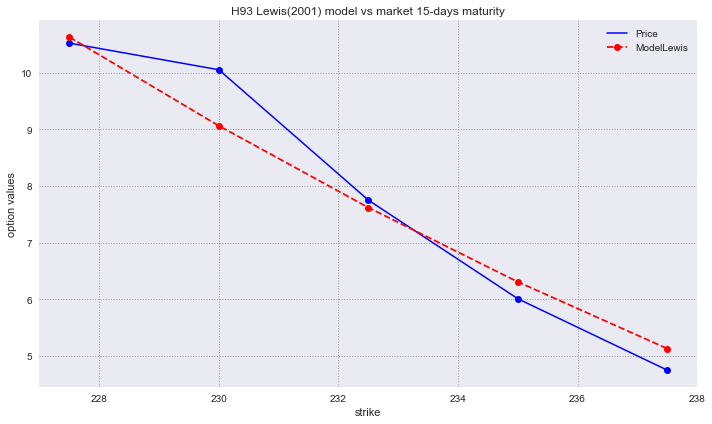

In [17]:
fig, ax = plt.subplots(1, 1)
options_filtered.plot(x="Strike", y="Price", style="bo-", lw=1.5, legend=True, ax=ax)
options_filtered.plot(x="Strike", y="ModelLewis", style="ro--", legend=True, ax=ax)
plt.xlabel("strike")
plt.ylabel("option values")
plt.title("H93 Lewis(2001) model vs market 15-days maturity")
plt.tight_layout()
plt.savefig("H93_Lewis_calibration_quotes.pdf")

#### Obtain put prices using put-call parity using call prices obtained above

Put call parity equation is:

$$c + K e^{-rt} = S_0 + p$$

In [18]:
print("Put prices using put-call parity:")
for row, option in options_filtered.iterrows():
    print(
        f'Strike: ${option["Strike"]:.2f}, Price: ${option["ModelLewis"] + option["Strike"] * exp(-option["r"]*option["T"])-S0:.2f}'
    )

Put prices using put-call parity:
Strike: $227.50, Price: $5.02
Strike: $230.00, Price: $5.95
Strike: $232.50, Price: $7.01
Strike: $235.00, Price: $8.20
Strike: $237.50, Price: $9.52


## Calibration with Carr-Madan (1999)

In [19]:
# Reset global variables for this calibration
i = 0
min_MSE = MAX_MSE_H93  # Initiate to highest value.

print("Starting brute force scanning...")
p0 = brute(
    H93_CM99_error_function,
    (
        (5, 10.1, 5.0),  # kappa_v
        (0.08, 0.14, 0.01),  # theta_v
        (0.6, 0.9, 0.1),  # sigma_v
        (-0.75, -0.5, 0.25),  # rho
        (0.01, 0.07, 0.01),
    ),  # v0
    finish=None,
)
print(f"Brute force params:{p0}")
print("Starting local scanning...")
# second run with local, convex minimization
# (dig deeper where promising)
opt_params_cm99 = fmin(
    H93_CM99_error_function, p0, xtol=0.00001, ftol=0.00001, maxiter=1500, maxfun=1700
)
np.save("H93_CM99_calibration_full_saved_params", np.array(opt_params_cm99))

Starting brute force scanning...
   0 | [ 5.    0.08  0.6  -0.75  0.01] |   9.112 |   9.112
  25 | [ 5.    0.09  0.7  -0.75  0.02] |  20.156 |   9.048
  50 | [ 5.    0.1   0.7  -0.75  0.03] |  30.194 |   9.048
  75 | [ 5.    0.11  0.7  -0.75  0.04] |  38.743 |   9.048
 100 | [ 5.    0.12  0.7  -0.75  0.05] |  45.875 |   9.048
 125 | [ 5.    0.13  0.7  -0.75  0.06] |  51.778 |   9.048
 150 | [ 5.    0.14  0.8  -0.75  0.01] |  17.972 |   9.048
 175 | [10.    0.08  0.8  -0.75  0.02] |  25.498 |   9.048
 200 | [10.    0.09  0.8  -0.75  0.03] |  34.810 |   9.048
 225 | [10.    0.1   0.8  -0.75  0.04] |  42.677 |   9.048
 250 | [10.    0.11  0.8  -0.75  0.05] |  49.227 |   9.048
 275 | [10.    0.12  0.8  -0.75  0.06] |  54.647 |   9.048
 300 | [10.    0.13  0.9  -0.75  0.01] |  29.947 |   9.048
 325 | [10.    0.14  0.9  -0.75  0.02] |  38.763 |   9.048
Brute force params:[ 5.    0.08  0.8  -0.75  0.01]
Starting local scanning...
 350 | [ 5.16579557  0.0681947   0.83362048 -0.77088488  0.0096

In [20]:
print("H93 Carr-Madan(2001) params:")
print(f"Κ_V:{round(opt_params_cm99[KAPPA_V],4)}")
print(f"Θ_V:{round(opt_params_cm99[THETA_V],4)}")
print(f"σ_V:{round(opt_params_cm99[SIGMA_V],4)}")
print(f"ρ:{round(opt_params_cm99[RHO],4)}")
print(f"v_0:{round(opt_params_cm99[V_0],4)}")

H93 Carr-Madan(2001) params:
Κ_V:6.1871
Θ_V:0.0306
σ_V:0.6157
ρ:-1.0
v_0:0.0028


In [21]:
options_filtered["ModelCM99"] = H93_CM99_calculate_model_values(opt_params_cm99)

In [22]:
np.sum(options_filtered["ModelCM99"] - options_filtered["Price"])

-0.07478811103847782

In [23]:
np.sum(abs(options_filtered["ModelCM99"] - options_filtered["Price"]))

1.81268205026627

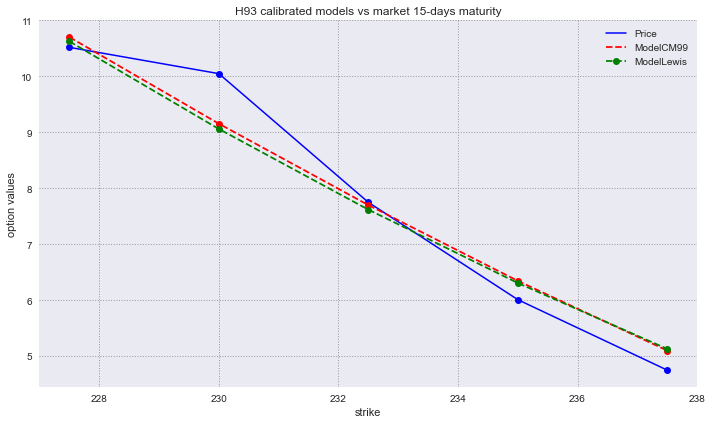

In [24]:
fig, ax = plt.subplots(1, 1)
options_filtered.plot(x="Strike", y="Price", style="bo-", lw=1.5, legend=True, ax=ax)
options_filtered.plot(x="Strike", y="ModelCM99", style="ro--", legend=True, ax=ax)
options_filtered.plot(x="Strike", y="ModelLewis", style="go--", legend=True, ax=ax)
plt.xlabel("strike")
plt.ylabel("option values")
plt.title("H93 calibrated models vs market 15-days maturity")
plt.tight_layout()
plt.savefig("H93_CM99_calibration_quotes.pdf")

Option market and Heston model prices:

In [25]:
options_filtered["ModelLewis%Diff"] = 1 - (
    options_filtered["ModelLewis"] / options_filtered["Price"]
)
options_filtered["ModelCM99%Diff"] = 1 - (
    options_filtered["ModelCM99"] / options_filtered["Price"]
)
options_filtered

,Days to maturity,Strike,Price,Type,T,r,ModelLewis,ModelCM99,ModelLewis%Diff,ModelCM99%Diff
0,15,227.5,10.52,C,0.06,0.015,10.626295,10.703213,-0.010104,-0.017416
1,15,230.0,10.05,C,0.06,0.015,9.061053,9.155532,0.098403,0.089002
2,15,232.5,7.75,C,0.06,0.015,7.619499,7.700733,0.016839,0.006357
3,15,235.0,6.01,C,0.06,0.015,6.307618,6.346148,-0.049521,-0.055931
4,15,237.5,4.75,C,0.06,0.015,5.130059,5.099586,-0.080013,-0.073597


### Obtain put prices using put-call parity using call prices obtained above

Put call parity equation is:

$$c + K e^{-rt} = S_0 + p$$


In [26]:
print("Put prices using put-call parity:")
for row, option in options_filtered.iterrows():
    print(
        f'Strike: ${option["Strike"]:.2f}, Price: ${option["ModelLewis"] + option["Strike"] * exp(-option["r"]*option["T"])-S0:.2f}'
    )

Put prices using put-call parity:
Strike: $227.50, Price: $5.02
Strike: $230.00, Price: $5.95
Strike: $232.50, Price: $7.01
Strike: $235.00, Price: $8.20
Strike: $237.50, Price: $9.52


## Calibration with Carr-Madan (1999)

In [27]:
# Reset global variables for this calibration
i = 0
min_MSE = MAX_MSE_H93  # Initiate to highest value.

print("Starting brute force scanning...")
p0 = brute(
    H93_CM99_error_function,
    (
        (5, 10.1, 5.0),  # kappa_v
        (0.08, 0.14, 0.01),  # theta_v
        (0.6, 0.9, 0.1),  # sigma_v
        (-0.75, -0.5, 0.25),  # rho
        (0.01, 0.07, 0.01),
    ),  # v0
    finish=None,
)
print(f"Brute force params:{p0}")
print("Starting local scanning...")
# second run with local, convex minimization
# (dig deeper where promising)
opt_params_cm99 = fmin(
    H93_CM99_error_function, p0, xtol=0.00001, ftol=0.00001, maxiter=1500, maxfun=1700
)
np.save("H93_CM99_calibration_full_saved_params", np.array(opt_params_cm99))

Starting brute force scanning...
   0 | [ 5.    0.08  0.6  -0.75  0.01] |   9.112 |   9.112
  25 | [ 5.    0.09  0.7  -0.75  0.02] |  20.156 |   9.048
  50 | [ 5.    0.1   0.7  -0.75  0.03] |  30.194 |   9.048
  75 | [ 5.    0.11  0.7  -0.75  0.04] |  38.743 |   9.048
 100 | [ 5.    0.12  0.7  -0.75  0.05] |  45.875 |   9.048
 125 | [ 5.    0.13  0.7  -0.75  0.06] |  51.778 |   9.048
 150 | [ 5.    0.14  0.8  -0.75  0.01] |  17.972 |   9.048
 175 | [10.    0.08  0.8  -0.75  0.02] |  25.498 |   9.048
 200 | [10.    0.09  0.8  -0.75  0.03] |  34.810 |   9.048
 225 | [10.    0.1   0.8  -0.75  0.04] |  42.677 |   9.048
 250 | [10.    0.11  0.8  -0.75  0.05] |  49.227 |   9.048
 275 | [10.    0.12  0.8  -0.75  0.06] |  54.647 |   9.048
 300 | [10.    0.13  0.9  -0.75  0.01] |  29.947 |   9.048
 325 | [10.    0.14  0.9  -0.75  0.02] |  38.763 |   9.048
Brute force params:[ 5.    0.08  0.8  -0.75  0.01]
Starting local scanning...
 350 | [ 5.16579557  0.0681947   0.83362048 -0.77088488  0.0096

In [28]:
print("H93 Carr-Madan(2001) params:")
print(f"Κ_V:{round(opt_params_cm99[KAPPA_V],4)}")
print(f"Θ_V:{round(opt_params_cm99[THETA_V],4)}")
print(f"σ_V:{round(opt_params_cm99[SIGMA_V],4)}")
print(f"ρ:{round(opt_params_cm99[RHO],4)}")
print(f"v_0:{round(opt_params_cm99[V_0],4)}")

H93 Carr-Madan(2001) params:
Κ_V:6.1871
Θ_V:0.0306
σ_V:0.6157
ρ:-1.0
v_0:0.0028


In [29]:
options_filtered["ModelCM99"] = H93_CM99_calculate_model_values(opt_params_cm99)

In [30]:
np.sum(options_filtered["ModelCM99"] - options_filtered["Price"])

-0.07478811103847782

In [31]:
np.sum(abs(options_filtered["ModelCM99"] - options_filtered["Price"]))

1.81268205026627

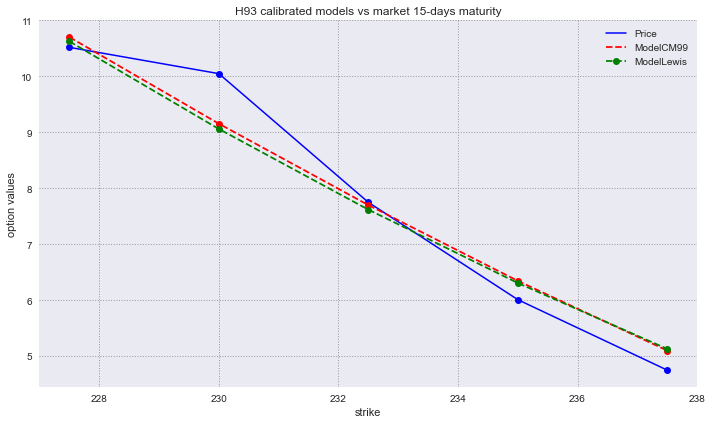

In [32]:
fig, ax = plt.subplots(1, 1)
options_filtered.plot(x="Strike", y="Price", style="bo-", lw=1.5, legend=True, ax=ax)
options_filtered.plot(x="Strike", y="ModelCM99", style="ro--", legend=True, ax=ax)
options_filtered.plot(x="Strike", y="ModelLewis", style="go--", legend=True, ax=ax)
plt.xlabel("strike")
plt.ylabel("option values")
plt.title("H93 calibrated models vs market 15-days maturity")
plt.tight_layout()
plt.savefig("H93_CM99_calibration_quotes.pdf")

Option market and Heston model prices:

In [33]:
options_filtered["ModelLewis%Diff"] = 1 - (
    options_filtered["ModelLewis"] / options_filtered["Price"]
)
options_filtered["ModelCM99%Diff"] = 1 - (
    options_filtered["ModelCM99"] / options_filtered["Price"]
)
options_filtered

,Days to maturity,Strike,Price,Type,T,r,ModelLewis,ModelCM99,ModelLewis%Diff,ModelCM99%Diff
0,15,227.5,10.52,C,0.06,0.015,10.626295,10.703213,-0.010104,-0.017416
1,15,230.0,10.05,C,0.06,0.015,9.061053,9.155532,0.098403,0.089002
2,15,232.5,7.75,C,0.06,0.015,7.619499,7.700733,0.016839,0.006357
3,15,235.0,6.01,C,0.06,0.015,6.307618,6.346148,-0.049521,-0.055931
4,15,237.5,4.75,C,0.06,0.015,5.130059,5.099586,-0.080013,-0.073597


### Obtain put prices using put-call parity using call prices obtained above

Put call parity equation is:

$$c + K e^{-rt} = S_0 + p$$


In [34]:
print("Put prices using put-call parity:")
for row, option in options_filtered.iterrows():
    print(
        f'Strike: ${option["Strike"]:.2f}, Price: ${option["ModelCM99"] + option["Strike"] * exp(-option["r"]*option["T"])-S0:.2f}'
    )

Put prices using put-call parity:
Strike: $227.50, Price: $5.10
Strike: $230.00, Price: $6.05
Strike: $232.50, Price: $7.09
Strike: $235.00, Price: $8.23
Strike: $237.50, Price: $9.49


## Monte Carlo pricing using calibrated model params

Monte Carlo Asian option pricing using Lewis(2001) approach params:

In [35]:
T = 20 / NUMBER_OF_TRADING_DAYS

print("Pricing with Lewis(2001) params...")
asian_option_lewis_mc = heston_model_mc_option_values(
    opt_params_lewis, T, ASIAN_OPTION, CALL_OPTION
)

Pricing with Lewis(2001) params...
Pricing Asian Call option using Monte Carlo simulation...
Option params: S0: 232.9, K:227.5, T:0.08, r:0.015, σ:0.7555821049398823
Model params: ν0:0.10540607982148842, κ:2.5955106405758466, θ:0.10997919120620023, ρ:-0.9999998910848666
 Asian option price using Heston model is $5.94
Pricing Asian Call option using Monte Carlo simulation...
Option params: S0: 232.9, K:230.0, T:0.08, r:0.015, σ:0.7555821049398823
Model params: ν0:0.10540607982148842, κ:2.5955106405758466, θ:0.10997919120620023, ρ:-0.9999998910848666
 Asian option price using Heston model is $4.53
Pricing Asian Call option using Monte Carlo simulation...
Option params: S0: 232.9, K:232.5, T:0.08, r:0.015, σ:0.7555821049398823
Model params: ν0:0.10540607982148842, κ:2.5955106405758466, θ:0.10997919120620023, ρ:-0.9999998910848666
 Asian option price using Heston model is $3.36
Pricing Asian Call option using Monte Carlo simulation...
Option params: S0: 232.9, K:235.0, T:0.08, r:0.015, σ:0

Asian call option price net of bank fees/commission: \
_Assignment does not provide a specific strike, so we apply fees and price all strikes from given data._ 

In [36]:
print(
    f"Price of Asian call option strike $232.9 is ${(1 + BANK_COMMISSION) * asian_option_lewis_mc[2]:.2f}"
)
print("Parameters used for pricing the option:")
print(f"S0:{round(S0,2)}")
print(f"S0:{round(T,2)}")
print(f"S0:{round(r,2)}")
print(f"Κ_V:{round(opt_params_lewis[KAPPA_V],2)}")
print(f"Θ_V:{round(opt_params_lewis[THETA_V],2)}")
print(f"σ_V:{round(opt_params_lewis[SIGMA_V],2)}")
print(f"ρ:{round(opt_params_lewis[RHO],2)}")
print(f"v_0:{round(opt_params_lewis[V_0],2)}")

Price of Asian call option strike $232.9 is $3.49
Parameters used for pricing the option:
S0:232.9
S0:0.08
S0:0.01
Κ_V:2.6
Θ_V:0.11
σ_V:0.76
ρ:-1.0
v_0:0.11


## Step 2:

### Bates (1996) Model

Set options maturity to match the instrument's maturity - 60 days for this part

In [37]:
# Set options filter to matching maturity
DAYS_TO_MATURITY = 60
set_options_data_filter(DAYS_TO_MATURITY)
options_filtered

,Days to maturity,Strike,Price,Type,T,r
5,60,227.5,16.78,C,0.24,0.015
6,60,230.0,17.65,C,0.24,0.015
7,60,232.5,16.86,C,0.24,0.015
8,60,235.0,16.05,C,0.24,0.015
9,60,237.5,15.10,C,0.24,0.015


## Calibration with Heston(93) with Lewis (2001) params

Here we will use params obtained after calibration of Heston(93) using Lewis(2001)

In [38]:
# Reset global variables for this calibration
i = 0
min_MSE = MAX_MSE_H93  # Initiate to highest value.


print("Starting brute force scanning...")
p0 = brute(
    H93_Lewis_error_function,
    (
        (5, 10.1, 5.0),  # kappa_v
        (0.2, 0.4, 0.1),  # theta_v
        (0.2, 0.6, 0.1),  # sigma_v
        (-0.75, -0.25, 0.25),  # rho
        (0.01, 0.08, 0.01),
    ),  # v0
    finish=None,
)
print(f"Brute force params:{p0}")
print("Starting local scanning...")
# second run with local, convex minimization
# (dig deeper where promising)
opt_params_lewis_60 = fmin(
    H93_Lewis_error_function,
    p0,
    xtol=0.000001,
    ftol=0.000001,
    maxiter=1200,
    maxfun=1500,
)
np.save("H93_Lewis_60_calibration_full_saved_params", np.array(opt_params_lewis_60))

Starting brute force scanning...
   0 | [ 5.    0.2   0.2  -0.75  0.01] |   6.566 |   6.566
  25 | [ 5.    0.2   0.3  -0.5   0.02] |   4.878 |   1.343
  50 | [ 5.    0.2   0.5  -0.75  0.03] |   4.000 |   1.343
  75 | [ 5.    0.3   0.2  -0.5   0.04] |   3.932 |   1.343
 100 | [ 5.    0.3   0.4  -0.75  0.05] |   4.865 |   1.343
 125 | [ 5.    0.3   0.5  -0.5   0.06] |   6.069 |   1.343
 150 | [10.    0.2   0.3  -0.75  0.07] |   4.298 |   1.343
 175 | [10.    0.2   0.4  -0.5   0.08] |   5.037 |   1.343
 200 | [10.    0.3   0.2  -0.5   0.01] |  16.536 |   1.343
 225 | [10.    0.3   0.4  -0.75  0.02] |  17.589 |   1.343
 250 | [10.    0.3   0.5  -0.5   0.03] |  19.108 |   1.343
Brute force params:[ 5.    0.2   0.2  -0.5   0.07]
Starting local scanning...
 275 | [ 5.05409692  0.19653489  0.20287116 -0.51616989  0.06961884] |   1.331 |   1.329
 300 | [ 5.31479717  0.19473435  0.20389272 -0.50256899  0.06633595] |   1.326 |   1.326
 325 | [ 7.3176469   0.19078202  0.20495832 -0.37425119  0.043

In [39]:
print("H93 Lewis(2001) params:")
print(f"Κ_V:{round(opt_params_lewis_60[KAPPA_V],4)}")
print(f"Θ_V:{round(opt_params_lewis_60[THETA_V],4)}")
print(f"σ_V:{round(opt_params_lewis_60[SIGMA_V],4)}")
print(f"ρ:{round(opt_params_lewis_60[RHO],4)}")
print(f"v_0:{round(opt_params_lewis_60[V_0],4)}")

H93 Lewis(2001) params:
Κ_V:0.7619
Θ_V:0.356
σ_V:0.736
ρ:1.0
v_0:0.1043


Partial Bates model calibration using paramters obtained for Heston(93)

In [40]:
i = 0
min_MSE = MAX_MSE_BATES

print("Starting brute force scanning...")
# First, we run with brute force
# (scan sensible regions)
opt_params_lewis_bates_initial = 0.0
opt_params_lewis_bates_initial = brute(
    B96_error_function,
    ((0.0, 0.51, 0.1), (-0.5, -0.11, 0.1), (0.0, 0.51, 0.25)),  # lambda  # mu  # delta
    args=opt_params_lewis_60,
    finish=None,
)
print(f"Brute force params:{opt_params_lewis_bates_initial}")
print("Starting local scanning...")
# Second, we run with local, convex minimization
# (dig deeper where promising)
opt_params_lewis_bates = fmin(
    B96_error_function,
    opt_params_lewis_bates_initial,
    args=(
        opt_params_lewis_60[KAPPA_V],
        opt_params_lewis_60[THETA_V],
        opt_params_lewis_60[SIGMA_V],
        opt_params_lewis_60[RHO],
        opt_params_lewis_60[V_0],
    ),
    xtol=0.0000001,
    ftol=0.0000001,
    maxiter=550,
    maxfun=750,
)
np.save("opt_params_lewis_bates_saved_params", np.array(opt_params_lewis_bates))

Starting brute force scanning...
   0 | [ 0.         -0.5         0.          0.76190692  0.35602555  0.73603581
  0.99999897  0.10432971] |   0.723 |   0.723
  25 | [ 0.2        -0.5         0.25        0.76190692  0.35602555  0.73603581
  0.99999897  0.10432971] |   2.356 |   0.723
  50 | [ 0.4        -0.5         0.5         0.76190692  0.35602555  0.73603581
  0.99999897  0.10432971] |  10.443 |   0.723
Brute force params:[ 0.  -0.2  0. ]
Starting local scanning...
  75 | [ 0.00000000e+00 -2.00000000e-01  2.50000000e-04  7.61906922e-01
  3.56025550e-01  7.36035808e-01  9.99998974e-01  1.04329706e-01] |   0.723 |   0.723
 100 | [ 2.50587448e-05 -1.99990593e-01  3.34371314e-05  7.61906922e-01
  3.56025550e-01  7.36035808e-01  9.99998974e-01  1.04329706e-01] |   0.723 |   0.723
 125 | [ 6.66716756e-07 -1.99999554e-01  1.22995115e-06  7.61906922e-01
  3.56025550e-01  7.36035808e-01  9.99998974e-01  1.04329706e-01] |   0.723 |   0.723
 150 | [ 6.77275993e-08 -2.00000007e-01  1.01087465e

Full Bates model calibration using all params obtained from previous calibrations

In [41]:
print("Bates (1996) using Lewis(2001) partially calibrated params:")
print(f"λ_0:{round(opt_params_lewis_bates[LAMBDA-LAMBDA],4)}")
print(f"μ_0:{round(opt_params_lewis_bates[MU-LAMBDA],4)}")
print(f"δ_0:{round(opt_params_lewis_bates[DELTA-LAMBDA],4)}")

Bates (1996) using Lewis(2001) partially calibrated params:
λ_0:0.0
μ_0:-0.2
δ_0:0.0


In [42]:
options_filtered["ModelLewisBates"] = B96_jump_calculate_model_values(
    opt_params_lewis_bates, opt_params_lewis_60
)
options_filtered

,Days to maturity,Strike,Price,Type,T,r,ModelLewisBates
5,60,227.5,16.78,C,0.24,0.015,18.457859
6,60,230.0,17.65,C,0.24,0.015,17.409575
7,60,232.5,16.86,C,0.24,0.015,16.421713
8,60,235.0,16.05,C,0.24,0.015,15.491018
9,60,237.5,15.10,C,0.24,0.015,14.614421


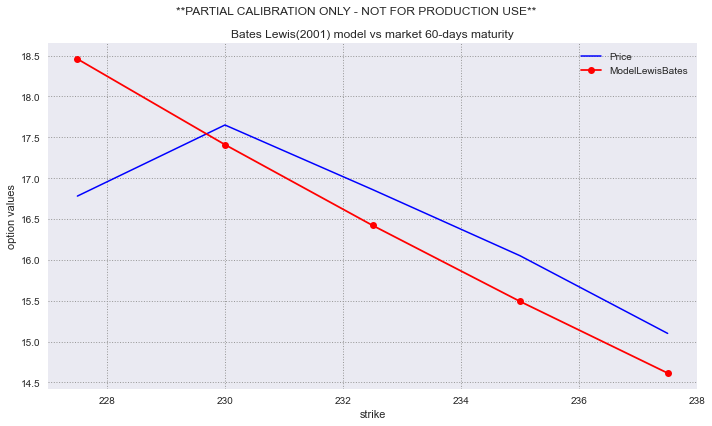

In [43]:
fig, ax = plt.subplots(1, 1)
options_filtered.plot(x="Strike", y="Price", style="b", lw=1.5, legend=True, ax=ax)
options_filtered.plot(x="Strike", y="ModelLewisBates", style="ro-", legend=True, ax=ax)
plt.xlabel("strike")
plt.ylabel("option values")
plt.title("Bates Lewis(2001) model vs market 60-days maturity")
plt.suptitle("**PARTIAL CALIBRATION ONLY - NOT FOR PRODUCTION USE**")
plt.tight_layout()
plt.savefig("H93_Lewis_calibration_quotes.pdf")

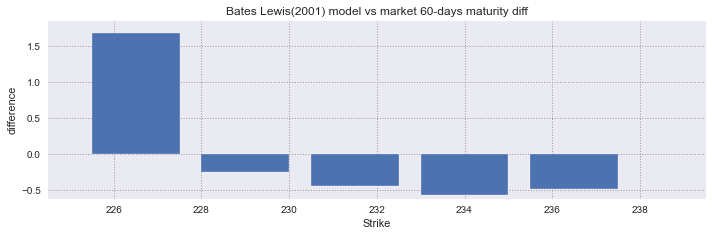

In [44]:
plt.subplot(212)
wi = 2.0
diffs = options_filtered.ModelLewisBates.values - options_filtered.Price.values
plt.bar(options_filtered.Strike.values - wi / 2, diffs, width=wi)
plt.title("Bates Lewis(2001) model vs market 60-days maturity diff")
plt.ylabel("difference")
plt.xlabel("Strike")
plt.axis(
    [
        min(options_filtered.Strike) - 3,
        max(options_filtered.Strike) + 2,
        min(diffs) * 1.1,
        max(diffs) * 1.1,
    ]
)

plt.tight_layout()

Perform full calibration of Bates model:

In [45]:
min_MSE = i = 0
min_MSE = MAX_MSE_BATES

opt_params_lewis_bates_full = fmin(
    B96_error_function_full,
    np.concatenate((opt_params_lewis_60, opt_params_lewis_bates)),
    xtol=0.001,
    ftol=0.001,
    maxiter=1250,
    maxfun=650,
)

   0 | [ 0.76190692  0.35602555  0.73603581  0.99999897  0.10432971  0.
 -0.2         0.        ] |   0.723 |   0.723
  25 | [ 7.67751341e-01  3.58280505e-01  7.35265495e-01  9.96893534e-01
  1.04061311e-01  5.34001453e-05 -2.02136006e-01  5.34001453e-05] |   0.725 |   0.723
  50 | [ 7.63168315e-01  3.56464475e-01  7.35928010e-01  9.99535888e-01
  1.04308942e-01  5.99001801e-05 -2.02396007e-01  5.99001801e-05] |   0.723 |   0.723
  75 | [ 7.62137815e-01  3.56107282e-01  7.36016665e-01  9.99916529e-01
  1.04326478e-01  6.20084754e-05 -2.02480339e-01  6.20084754e-05] |   0.723 |   0.723
 100 | [ 7.61953020e-01  3.56041987e-01  7.36031991e-01  9.99982543e-01
  1.04329073e-01  5.58094650e-05 -2.02583941e-01  6.45985275e-05] |   0.723 |   0.723
 125 | [ 7.61912517e-01  3.56027548e-01  7.36035345e-01  9.99996982e-01
  1.04329630e-01  2.12074718e-05 -2.03049927e-01  7.62481668e-05] |   0.723 |   0.723
 150 | [ 7.61906672e-01  3.56025466e-01  7.36035829e-01  9.99999065e-01
  1.04329710e-01  6.

In [46]:
print("Bates (1996) using Lewis(2001) calibrated params:")
print(f"Κ_V:{round(opt_params_lewis_bates_full[KAPPA_V],4)}")
print(f"Θ_V:{round(opt_params_lewis_bates_full[THETA_V],4)}")
print(f"σ_V:{round(opt_params_lewis_bates_full[SIGMA_V],4)}")
print(f"ρ:{round(opt_params_lewis_bates_full[RHO],4)}")
print(f"v_0:{round(opt_params_lewis_bates_full[V_0],4)}")
print(f"λ_0:{round(opt_params_lewis_bates_full[LAMBDA],4)}")
print(f"μ_0:{round(opt_params_lewis_bates_full[MU],4)}")
print(f"δ_0:{round(opt_params_lewis_bates_full[DELTA],4)}")

Bates (1996) using Lewis(2001) calibrated params:
Κ_V:0.7619
Θ_V:0.356
σ_V:0.736
ρ:1.0
v_0:0.1043
λ_0:0.0
μ_0:-0.2005
δ_0:0.0001


In [47]:
options_filtered["ModelLewisBatesFull"] = B96_jump_calculate_model_values(
    opt_params_lewis_bates_full
)
options_filtered

,Days to maturity,Strike,Price,Type,T,r,ModelLewisBates,ModelLewisBatesFull
5,60,227.5,16.78,C,0.24,0.015,18.457859,18.457856
6,60,230.0,17.65,C,0.24,0.015,17.409575,17.409571
7,60,232.5,16.86,C,0.24,0.015,16.421713,16.421710
8,60,235.0,16.05,C,0.24,0.015,15.491018,15.491015
9,60,237.5,15.10,C,0.24,0.015,14.614421,14.614418


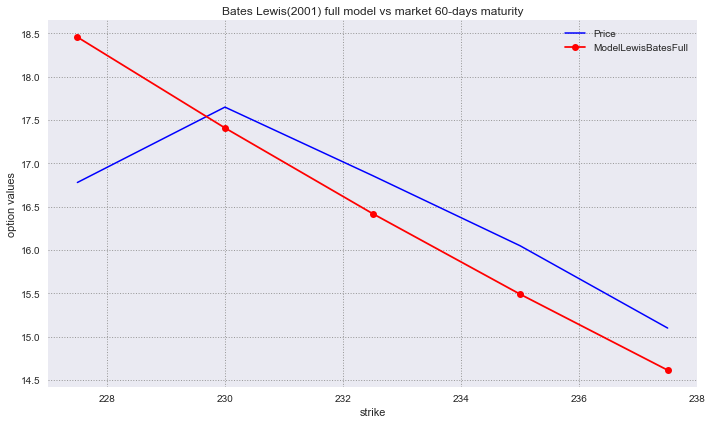

In [48]:
fig, ax = plt.subplots(1, 1)
options_filtered.plot(x="Strike", y="Price", style="b", lw=1.5, legend=True, ax=ax)
options_filtered.plot(
    x="Strike", y="ModelLewisBatesFull", style="ro-", legend=True, ax=ax
)
plt.xlabel("strike")
plt.ylabel("option values")
plt.title("Bates Lewis(2001) full model vs market 60-days maturity")
plt.tight_layout()

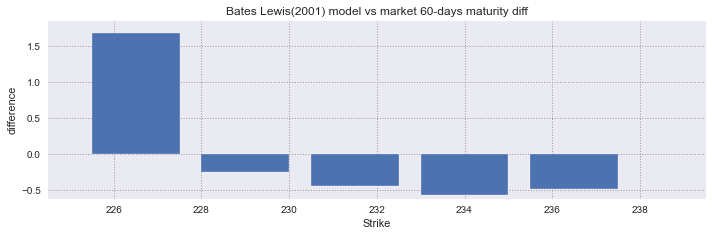

In [49]:
plt.subplot(212)
wi = 2.0
diffs = options_filtered.ModelLewisBatesFull.values - options_filtered.Price.values
plt.bar(options_filtered.Strike.values - wi / 2, diffs, width=wi)
plt.title("Bates Lewis(2001) model vs market 60-days maturity diff")
plt.ylabel("difference")
plt.xlabel("Strike")
plt.axis(
    [
        min(options_filtered.Strike) - 3,
        max(options_filtered.Strike) + 2,
        min(diffs) * 1.1,
        max(diffs) * 1.1,
    ]
)

plt.tight_layout()

 ### Obtain put prices using put-call parity using call prices obtained above
 
 Put call parity equation is:

$$c + K e^{-rt} = S_0 + p$$


In [50]:
print("Put prices using put-call parity:")
for row, option in options_filtered.iterrows():
    print(
        f'Strike: ${option["Strike"]:.2f}, Price: ${option["ModelLewisBatesFull"] + option["Strike"] * exp(-option["r"]*option["T"])-S0:.2f}'
    )

Put prices using put-call parity:
Strike: $227.50, Price: $12.24
Strike: $230.00, Price: $13.68
Strike: $232.50, Price: $15.19
Strike: $235.00, Price: $16.75
Strike: $237.50, Price: $18.36


## Calibration with Heston(93) with Carr-Madan (1999) params

In [51]:
# Reset global variables for this calibration
i = 0
min_MSE = MAX_MSE_H93  # Initiate to highest value.

print("Starting brute force scanning...")
p0 = brute(
    H93_CM99_error_function,
    (
        (0, 10.1, 5.0),  # kappa_v
        (0.12, 0.2, 0.01),  # theta_v
        (1.0, 1.3, 0.1),  # sigma_v
        (-0.25, 0.0, 0.25),  # rho
        (0.05, 0.1, 0.01),
    ),  # v0
    finish=None,
)
print(f"Brute force params:{p0}")
print("Starting local scanning...")
# second run with local, convex minimization
# (dig deeper where promising)
opt_params_cm99_60 = fmin(
    H93_CM99_error_function, p0, xtol=0.00001, ftol=0.00001, maxiter=1500, maxfun=1700
)
np.save("H93_CM99_calibration_full_saved_params", np.array(opt_params_cm99))

Starting brute force scanning...
   0 | [ 5.    0.12  1.   -0.25  0.05] |   0.411 |   0.411
  25 | [ 5.    0.15  1.   -0.25  0.05] |   0.623 |   0.411
  50 | [ 5.    0.16  1.2  -0.25  0.05] |   0.566 |   0.411
  75 | [ 5.    0.18  1.   -0.25  0.05] |   1.007 |   0.411
 100 | [ 5.    0.19  1.1  -0.25  0.05] |   1.025 |   0.411
 125 | [ 5.    0.2   1.2  -0.25  0.05] |   1.048 |   0.411
 150 | [10.    0.12  1.3  -0.25  0.05] |   0.665 |   0.411
 175 | [10.    0.14  1.   -0.25  0.05] |   1.497 |   0.411
 200 | [10.    0.15  1.1  -0.25  0.05] |   1.656 |   0.411
 225 | [10.    0.16  1.2  -0.25  0.05] |   1.830 |   0.411
 250 | [10.    0.17  1.3  -0.25  0.05] |   2.018 |   0.411
 275 | [10.    0.19  1.   -0.25  0.05] |   3.684 |   0.411
 300 | [10.    0.2   1.1  -0.25  0.05] |   3.937 |   0.411
Brute force params:[ 5.    0.12  1.   -0.25  0.05]
Starting local scanning...
 325 | [ 4.9296    0.114624  1.06272  -0.26568   0.049536] |   0.318 |   0.317
 350 | [ 4.72562451  0.1068398   0.97266923

Here we will use params obtained after calibration of Heston(93) using Carr-Madan(1999)

In [52]:
print("H93 Carr-Madan(1999) params:")
print(f"Κ_V:{round(opt_params_cm99_60[KAPPA_V],2)}")
print(f"Θ_V:{round(opt_params_cm99_60[THETA_V],2)}")
print(f"σ_V:{round(opt_params_cm99_60[SIGMA_V],2)}")
print(f"ρ:{round(opt_params_cm99_60[RHO],2)}")
print(f"v_0:{round(opt_params_cm99_60[V_0],2)}")

H93 Carr-Madan(1999) params:
Κ_V:3.16
Θ_V:0.11
σ_V:0.85
ρ:-0.39
v_0:0.1


Partial Bates model calibration using paramters obtained for Heston(93)

In [53]:
i = 0
min_MSE = MAX_MSE_BATES
USE_REGULARIZATION = True

print("Starting brute force scanning...")
# First, we run with brute force
# (scan sensible regions)
opt_params_cm_bates_initial = 0.0
opt_params_cm_bates_initial = brute(
    B96_error_function,
    ((-0.5, 0.51, 0.1), (-0.5, -0.11, 0.1), (-0.25, 0.75, 0.25)),  # lambda  # mu  #
    args=opt_params_cm99_60,
    finish=None,
)
print(f"Brute force params:{opt_params_lewis_bates_initial}")
print("Starting local scanning...")
# Second, we run with local, convex minimization
# (dig deeper where promising)
opt_params_cm_bates = fmin(
    B96_error_function,
    opt_params_cm_bates_initial,
    args=(
        opt_params_cm99_60[KAPPA_V],
        opt_params_cm99_60[THETA_V],
        opt_params_cm99_60[SIGMA_V],
        opt_params_cm99_60[RHO],
        opt_params_cm99_60[V_0],
    ),
    xtol=0.0000001,
    ftol=0.0000001,
    maxiter=550,
    maxfun=750,
)
np.save("opt_params_lewis_bates_saved_params", np.array(opt_params_cm_bates))

Starting brute force scanning...
   0 | [ 0.         -0.5         0.          3.15989533  0.11461139  0.85106993
 -0.38610365  0.09947807] |   4.811 |   4.811
  25 | [ 0.2        -0.5         0.25        3.15989533  0.11461139  0.85106993
 -0.38610365  0.09947807] |   1.809 |   1.809
  50 | [ 0.4        -0.5         0.5         3.15989533  0.11461139  0.85106993
 -0.38610365  0.09947807] |   7.191 |   1.649
Brute force params:[ 0.  -0.2  0. ]
Starting local scanning...
  75 | [ 3.00000000e-01 -3.00000000e-01  2.50000000e-04  3.15989533e+00
  1.14611395e-01  8.51069929e-01 -3.86103650e-01  9.94780720e-02] |   1.797 |   1.649
 100 | [ 2.78893853e-01 -3.43845320e-01  1.33314917e-04  3.15989533e+00
  1.14611395e-01  8.51069929e-01 -3.86103650e-01  9.94780720e-02] |   1.752 |   1.649
 125 | [ 2.78993117e-01 -3.46032449e-01  1.63712840e-04  3.15989533e+00
  1.14611395e-01  8.51069929e-01 -3.86103650e-01  9.94780720e-02] |   1.750 |   1.649
 150 | [ 2.78494226e-01 -3.46563033e-01  1.67712967e

Full Bates model calibration using all params obtained from previous calibrations

In [54]:
opt_params_cm_bates

array([ 2.78504999e-01, -3.46548686e-01,  1.28559553e-07])

In [55]:
options_filtered["ModelCMBates"] = B96_jump_calculate_model_values(
    opt_params_cm_bates, opt_params_cm99
)
options_filtered

,Days to maturity,Strike,Price,Type,T,r,ModelLewisBates,ModelLewisBatesFull,ModelCMBates
5,60,227.5,16.78,C,0.24,0.015,18.457859,18.457856,12.410573
6,60,230.0,17.65,C,0.24,0.015,17.409575,17.409571,10.546778
7,60,232.5,16.86,C,0.24,0.015,16.421713,16.421710,8.771185
8,60,235.0,16.05,C,0.24,0.015,15.491018,15.491015,7.099219
9,60,237.5,15.10,C,0.24,0.015,14.614421,14.614418,5.548763


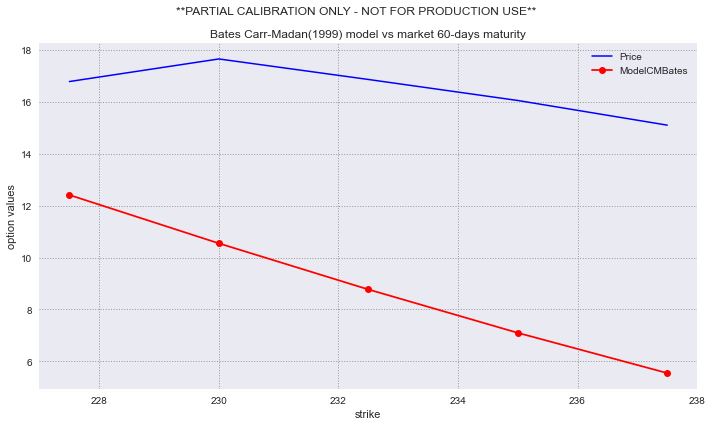

In [56]:
fig, ax = plt.subplots(1, 1)
options_filtered.plot(x="Strike", y="Price", style="b", lw=1.5, legend=True, ax=ax)
options_filtered.plot(x="Strike", y="ModelCMBates", style="ro-", legend=True, ax=ax)
plt.xlabel("strike")
plt.ylabel("option values")
plt.title("Bates Carr-Madan(1999) model vs market 60-days maturity")
plt.suptitle("**PARTIAL CALIBRATION ONLY - NOT FOR PRODUCTION USE**")
plt.tight_layout()
plt.savefig("H93_CM99_calibration_quotes.pdf")

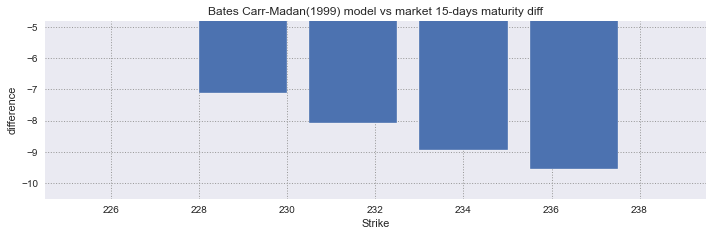

In [57]:
plt.subplot(212)
wi = 2.0
diffs = options_filtered.ModelCMBates.values - options_filtered.Price.values
plt.bar(options_filtered.Strike.values - wi / 2, diffs, width=wi)
plt.title("Bates Carr-Madan(1999) model vs market 15-days maturity diff")
plt.ylabel("difference")
plt.xlabel("Strike")
plt.axis(
    [
        min(options_filtered.Strike) - 3,
        max(options_filtered.Strike) + 2,
        min(diffs) * 1.1,
        max(diffs) * 1.1,
    ]
)

plt.tight_layout()

Perform full calibration of Bates model:

In [58]:
opt_params_cm_bates_full = fmin(
    B96_error_function_full,
    np.concatenate((opt_params_cm99_60, opt_params_cm_bates)),
    xtol=0.001,
    ftol=0.001,
    maxiter=1250,
    maxfun=650,
)

 300 | [ 3.15989533e+00  1.14611395e-01  8.51069929e-01 -3.86103650e-01
  9.94780720e-02  2.78504999e-01 -3.46548686e-01  1.34987531e-07] |   1.750 |   1.649
 325 | [ 3.60250326e+00  1.25580864e-01  8.22396585e-01 -3.47052334e-01
  1.03564129e-01  2.78557341e-01 -2.75746946e-01  1.29886236e-07] |   1.600 |   1.600
 350 | [ 4.15924919e+00  1.43652481e-01  7.20203156e-01 -2.92720650e-01
  1.09638482e-01  2.78598952e-01 -1.45620857e-01  1.36592090e-07] |   1.433 |   1.411
 375 | [ 4.54175777e+00  1.53896200e-01  6.87546428e-01 -2.48478191e-01
  1.05777518e-01  2.75363492e-01 -8.87963635e-02  1.44767618e-07] |   1.387 |   1.372
 400 | [ 6.23075800e+00  1.80745019e-01  6.19145569e-01 -3.35352492e-02
  7.54764468e-02  1.69385938e-01 -4.03177899e-02  1.94870040e-07] |   1.300 |   1.297
 425 | [ 6.70555537e+00  1.65414543e-01  6.11943133e-01  1.54320404e-02
  7.42140048e-02  1.12334278e-01 -7.55440042e-02  2.23208163e-07] |   1.305 |   1.237
 450 | [ 8.40284617e+00  1.77203577e-01  5.51163904e

In [59]:
print("Bates (1996) using Carr-Madan(1999) calibrated params:")
print(f"Κ_V:{round(opt_params_cm_bates_full[KAPPA_V],2)}")
print(f"Θ_V:{round(opt_params_cm_bates_full[THETA_V],2)}")
print(f"σ_V:{round(opt_params_cm_bates_full[SIGMA_V],2)}")
print(f"ρ:{round(opt_params_cm_bates_full[RHO],2)}")
print(f"v_0:{round(opt_params_cm_bates_full[V_0],2)}")
print(f"λ_0:{round(opt_params_cm_bates_full[LAMBDA],2)}")
print(f"μ_0:{round(opt_params_cm_bates_full[MU],2)}")
print(f"δ_0:{round(opt_params_cm_bates_full[DELTA],2)}")

Bates (1996) using Carr-Madan(1999) calibrated params:
Κ_V:14.4
Θ_V:0.17
σ_V:1.08
ρ:1.0
v_0:0.0
λ_0:0.14
μ_0:-0.0
δ_0:0.0


In [60]:
options_filtered["ModelCMBatesFull"] = B96_jump_calculate_model_values(
    opt_params_cm_bates_full
)
options_filtered

,Days to maturity,Strike,Price,Type,T,r,ModelLewisBates,ModelLewisBatesFull,ModelCMBates,ModelCMBatesFull
5,60,227.5,16.78,C,0.24,0.015,18.457859,18.457856,12.410573,18.644495
6,60,230.0,17.65,C,0.24,0.015,17.409575,17.409571,10.546778,17.500380
7,60,232.5,16.86,C,0.24,0.015,16.421713,16.421710,8.771185,16.420280
8,60,235.0,16.05,C,0.24,0.015,15.491018,15.491015,7.099219,15.401690
9,60,237.5,15.10,C,0.24,0.015,14.614421,14.614418,5.548763,14.442033


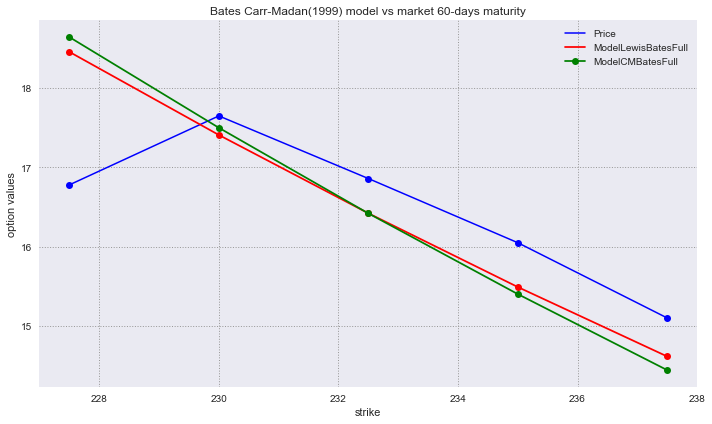

In [61]:
fig, ax = plt.subplots(1, 1)
options_filtered.plot(x="Strike", y="Price", style="bo-", lw=1.5, legend=True, ax=ax)
options_filtered.plot(x="Strike", y="ModelLewisBatesFull", style="ro-", legend=True, ax=ax)
options_filtered.plot(x="Strike", y="ModelCMBatesFull", style="go-", legend=True, ax=ax)
plt.xlabel("strike")
plt.ylabel("option values")
plt.title("Bates Carr-Madan(1999) model vs market 60-days maturity")
plt.tight_layout()
plt.savefig("H93_CM99_calibration_quotes.pdf")

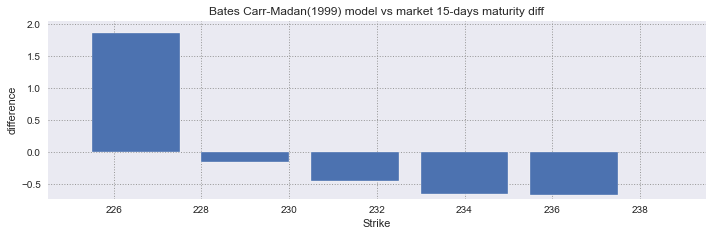

In [62]:
plt.subplot(212)
wi = 2.0
diffs = options_filtered.ModelCMBatesFull.values - options_filtered.Price.values
plt.bar(options_filtered.Strike.values - wi / 2, diffs, width=wi)
plt.title("Bates Carr-Madan(1999) model vs market 15-days maturity diff")
plt.ylabel("difference")
plt.xlabel("Strike")
plt.axis(
    [
        min(options_filtered.Strike) - 3,
        max(options_filtered.Strike) + 2,
        min(diffs) * 1.1,
        max(diffs) * 1.1,
    ]
)

plt.tight_layout()

### Obtain put prices using put-call parity using call prices obtained above

Put call parity equation is:

$$c + K e^{-rt} = S_0 + p$$


In [63]:
print("Put prices using put-call parity:")
for row, option in options_filtered.iterrows():
    print(
        f'Strike: ${option["Strike"]:.2f}, Price: ${option["ModelCMBatesFull"] + option["Strike"] * exp(-option["r"]*option["T"])-S0:.2f}'
    )

Put prices using put-call parity:
Strike: $227.50, Price: $12.43
Strike: $230.00, Price: $13.77
Strike: $232.50, Price: $15.18
Strike: $235.00, Price: $16.66
Strike: $237.50, Price: $18.19


## Monte Carlo pricing using calibrated params

Price vanilla put option uisng calibrated params obtained above

In [64]:
T_bates = 70 / NUMBER_OF_TRADING_DAYS

print("Pricing with Bates Lewis(2001) params...")
european_option_lewis_bates_mc = heston_model_mc_option_values(
    opt_params_lewis_bates_full[KAPPA_V : V_0 + 1], T_bates, EUROPEAN_OPTION, PUT_OPTION
)

print("\nPricing with Bates Carr-Madan params...")
european_option_cm99_bates_mc = heston_model_mc_option_values(
    opt_params_cm_bates_full[KAPPA_V : V_0 + 1], T_bates, EUROPEAN_OPTION, PUT_OPTION
)

Pricing with Bates Lewis(2001) params...
Pricing European Put option using Monte Carlo simulation...
Option params: S0: 232.9, K:227.5, T:0.28, r:0.015, σ:0.7360359014381317
Model params: ν0:0.10432972166668461, κ:0.7619057945721124, θ:0.35602515011135155, ρ:0.9999993766827038
 European option price using Heston model is $3.76
Pricing European Put option using Monte Carlo simulation...
Option params: S0: 232.9, K:230.0, T:0.28, r:0.015, σ:0.7360359014381317
Model params: ν0:0.10432972166668461, κ:0.7619057945721124, θ:0.35602515011135155, ρ:0.9999993766827038
 European option price using Heston model is $4.54
Pricing European Put option using Monte Carlo simulation...
Option params: S0: 232.9, K:232.5, T:0.28, r:0.015, σ:0.7360359014381317
Model params: ν0:0.10432972166668461, κ:0.7619057945721124, θ:0.35602515011135155, ρ:0.9999993766827038
 European option price using Heston model is $5.47
Pricing European Put option using Monte Carlo simulation...
Option params: S0: 232.9, K:235.0, 

In [65]:
net_european_lewis_bates_option_mc = pd.DataFrame(
    columns=["NetPrice"],
    index=options_filtered["Strike"],
    data=european_option_lewis_bates_mc,
)
net_european_cm99_bates_option_bates_mc = pd.DataFrame(
    columns=["NetPrice"],
    index=options_filtered["Strike"],
    data=european_option_cm99_bates_mc,
)

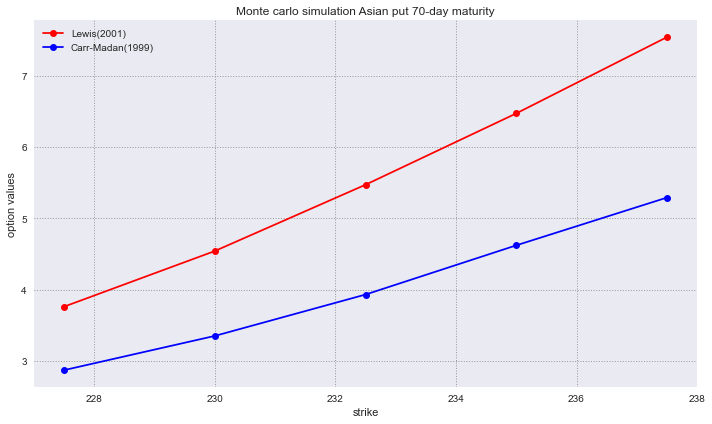

In [66]:
fig, ax = plt.subplots(1, 1)
net_european_lewis_bates_option_mc.plot(style="ro-", legend=True, ax=ax)
net_european_cm99_bates_option_bates_mc.plot(style="bo-", legend=True, ax=ax)
ax.legend(["Lewis(2001)", "Carr-Madan(1999)"])
plt.xlabel("strike")
plt.ylabel("option values")
plt.title("Monte carlo simulation Asian put 70-day maturity")
plt.tight_layout()

### Price 70-day with 95%-moneyness put option for the client given calibrated params:

In [67]:
T_bates = 70 / NUMBER_OF_TRADING_DAYS
K_bates = 0.95 * S0

european_option_lewis_bates_mc_value = heston_model_mc_option_value(
    S0,
    K_bates,
    T_bates,
    r,
    opt_params_lewis_bates_full[SIGMA_V],
    EUROPEAN_OPTION,
    PUT_OPTION,
    opt_params_lewis_bates_full[V_0],
    opt_params_lewis_bates_full[KAPPA_V],
    opt_params_lewis_bates_full[THETA_V],
    opt_params_lewis_bates_full[RHO],
)
print(
    f"Net of fees put option price using Bates Lewis(2001) params is : ${round(european_option_lewis_bates_mc_value * (1 + BANK_COMMISSION),2)}\n"
)

european_option_cm99_bates_mc_value = heston_model_mc_option_value(
    S0,
    K_bates,
    T_bates,
    r,
    opt_params_cm_bates_full[SIGMA_V],
    EUROPEAN_OPTION,
    PUT_OPTION,
    opt_params_cm_bates_full[V_0],
    opt_params_cm_bates_full[KAPPA_V],
    opt_params_cm_bates_full[THETA_V],
    opt_params_cm_bates_full[RHO],
)

print(
    f"Net of fees option price using Bates Carr-Madan(1999) params is : ${round(european_option_cm99_bates_mc_value * (1 + BANK_COMMISSION),2)}"
)

Pricing European Put option using Monte Carlo simulation...
Option params: S0: 232.9, K:221.255, T:0.28, r:0.015, σ:0.7360359014381317
Model params: ν0:0.10432972166668461, κ:0.7619057945721124, θ:0.35602515011135155, ρ:0.9999993766827038
 European option price using Heston model is $1.99
Net of fees put option price using Bates Lewis(2001) params is : $2.07

Pricing European Put option using Monte Carlo simulation...
Option params: S0: 232.9, K:221.255, T:0.28, r:0.015, σ:1.082857198886762
Model params: ν0:5.733546891600644e-07, κ:14.39669931237983, θ:0.17198035067671968, ρ:0.9997831061339997
 European option price using Heston model is $1.78
Net of fees option price using Bates Carr-Madan(1999) params is : $1.85


# Step 3

##  COX-INGERSOLL-ROSS (1996) MODEL

###   Calibration of CIR(1985) model

In [68]:
maturities = np.array((7, 30, 90, 180, 360)) / NUMBER_OF_DAYS_RATES
rates = np.array((0.648, 0.679, 1.173, 1.809, 2.556)) / 100

r0 = rates[0]
factors = 1 + maturities * rates
zero_rates = 1 / maturities * np.log(factors)

# interpolate rates
bspline = splrep(maturities, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(0.0, 1.0, 52)  # Weekly maturities
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
forward_rates_cspline = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

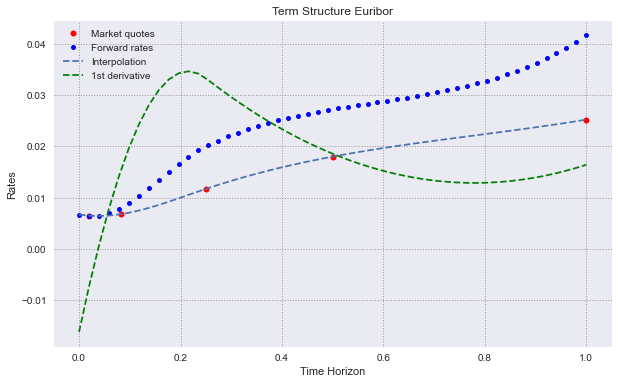

In [69]:
plt.plot(maturities, zero_rates, "r.", markersize="12", label="Market quotes")
plt.plot(
    mat_list_n, forward_rates_cspline, "b.", markersize="10", label="Forward rates"
)
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Rates")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

In [70]:
print("Starting brute force scanning...")
opt_params_cir_initial = brute(
    CIR_error_function,
    (
        (1.1, 2, 0.01),  # kappa_v
        (0.05, 0.07, 0.01),  # theta_v
        (0.03, 0.09, 0.01),
    ),  # sigma
    finish=None,
)
print(f"Brute force params: {opt_params_cir_initial}")
print("Starting local scanning...")
opt_params_cir = fmin(
    CIR_error_function,
    opt_params_cir_initial,
    xtol=0.00001,
    ftol=0.00001,
    maxiter=400,
    maxfun=700,
)

Starting brute force scanning...
 725 | [1.1  0.06 0.03] | 0.00008 | 0.00008
 750 | [1.11 0.07 0.04] | 0.00004 | 0.00004
 775 | [1.13 0.05 0.05] | 0.00011 | 0.00004
 800 | [1.14 0.06 0.06] | 0.00007 | 0.00004
 825 | [1.15 0.07 0.07] | 0.00004 | 0.00004
 850 | [1.17 0.05 0.08] | 0.00011 | 0.00004
 875 | [1.18 0.07 0.03] | 0.00003 | 0.00003
 900 | [1.2  0.05 0.04] | 0.00010 | 0.00003
 925 | [1.21 0.06 0.05] | 0.00006 | 0.00003
 950 | [1.22 0.07 0.06] | 0.00003 | 0.00003
 975 | [1.24 0.05 0.07] | 0.00010 | 0.00003
1000 | [1.25 0.06 0.08] | 0.00005 | 0.00003
1025 | [1.27 0.05 0.03] | 0.00009 | 0.00003
1050 | [1.28 0.06 0.04] | 0.00005 | 0.00002
1075 | [1.29 0.07 0.05] | 0.00002 | 0.00002
1100 | [1.31 0.05 0.06] | 0.00009 | 0.00002
1125 | [1.32 0.06 0.07] | 0.00005 | 0.00002
1150 | [1.33 0.07 0.08] | 0.00002 | 0.00002
1175 | [1.35 0.06 0.03] | 0.00004 | 0.00002
1200 | [1.36 0.07 0.04] | 0.00002 | 0.00002
1225 | [1.38 0.05 0.05] | 0.00008 | 0.00002
1250 | [1.39 0.06 0.06] | 0.00004 | 0.00002

In [71]:
print("CIR calibrated params:")
print(f"κ_r :{round(opt_params_cir[KAPPA_R],3)}")
print(f"θ_r :{round(opt_params_cir[THETA_R],3)}")
print(f"σ_r :{round(opt_params_cir[SIGMA_R],3)}")

CIR calibrated params:
κ_r :0.999
θ_r :0.107
σ_r :0.001


## Monte Carlo simulation CIR(1985) model

In [72]:
opt_params_cir

array([0.99871992, 0.10742945, 0.00100053])

In [73]:
r0 = zero_rates[0]
T = 1

iterations = 100_000
steps = NUMBER_OF_DAYS_RATES

cir_rate_paths = cir_model_paths(
    r0,
    opt_params_cir[KAPPA_R],
    opt_params_cir[THETA_R],
    opt_params_cir[SIGMA_R],
    T,
    steps,
    iterations,
)

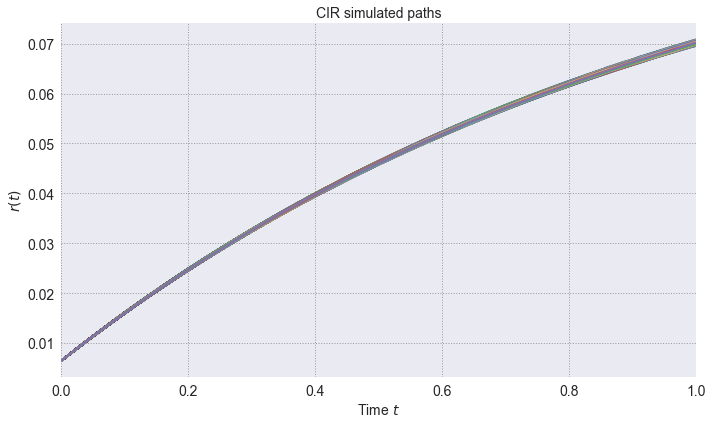

In [74]:
t = np.linspace(0, T, steps)
for j in range(iterations):
    plt.plot(t, cir_rate_paths[:, j])
cir_rate_paths_df = pd.DataFrame(cir_rate_paths)
rate_path = cir_rate_paths_df.rolling(steps).mean()
rate_std = 3 * cir_rate_paths_df.rolling(steps).std()

lower_line = (rate_path - rate_std)[0]
upper_line = (rate_path + rate_std)[0]

# plt.fill_between(rate_path.index, lower_line, upper_line, color='b', alpha=.1) #std curves.
plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("$r(t)$", fontsize=14)
plt.title("CIR simulated paths", fontsize=14)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [75]:
cir_rate_paths.shape

(360, 100000)

In [76]:
rate_mean_1yr = np.mean(cir_rate_paths[-1])
rate_std_1yr = np.std(cir_rate_paths[-1])
critical_value_95 = 1.96

print(f"Start rate r0: {r0:.4%}")
print(
    f"1-year expected range is between {np.min(cir_rate_paths[-1]):.4%} - {np.max(cir_rate_paths[-1]):.4%}"
)
print(f"1-year expected value is : {rate_mean_1yr:.4%}")
print(f"1-year std dev is : {rate_std_1yr:.4%}")
print(
    f"95% confidence interval for 1-year rate is : \
      ({rate_mean_1yr - critical_value_95 * rate_std_1yr:.4%}, {rate_mean_1yr + critical_value_95 * rate_std_1yr:.4%})"
)

Start rate r0: 0.6480%
1-year expected range is between 6.9525% - 7.0839%
1-year expected value is : 7.0192%
1-year std dev is : 0.0151%
95% confidence interval for 1-year rate is :       (6.9896%, 7.0489%)
